# Example usage

The Viam SDK can be used in two ways:
1. As a client to connect to a (remote or local) robot
2. To create custom components and provide additional functionality to a robot

## Connect as a client

To connect to a robot as a client, you should instantiate an instance of a `RobotClient`

In [4]:
# Please excuse the boilerplate
%autoawait asyncio
import warnings
warnings.filterwarnings('ignore')

In [5]:
from viam import logging
from viam.robot.client import RobotClient
from viam.rpc.dial import DialOptions

async def connect() -> RobotClient:
    options = RobotClient.Options(
        dial_options=DialOptions(insecure=True),
        log_level=logging.FATAL
    )
    return await RobotClient.at_address('0.0.0.0:5432', options)

robot = await connect()
print(robot.resource_names)
await robot.close()

[namespace: "rdk"
type: "component"
subtype: "arm"
name: "arm0"
, namespace: "rdk"
type: "component"
subtype: "base"
name: "base0"
, namespace: "rdk"
type: "component"
subtype: "board"
name: "board"
, namespace: "rdk"
type: "component"
subtype: "camera"
name: "camera0"
, namespace: "rdk"
type: "component"
subtype: "gantry"
name: "gantry0"
, namespace: "rdk"
type: "component"
subtype: "gripper"
name: "gripper0"
, namespace: "rdk"
type: "component"
subtype: "motor"
name: "motor0"
, namespace: "rdk"
type: "component"
subtype: "movement_sensor"
name: "movement_sensor0"
, namespace: "rdk"
type: "component"
subtype: "pose_tracker"
name: "pose_tracker0"
, namespace: "rdk"
type: "component"
subtype: "sensor"
name: "sensor0"
, namespace: "rdk"
type: "component"
subtype: "servo"
name: "servo0"
]


You can also create a `RobotClient` by providing an existing connection

In [3]:
from viam import logging
from viam.robot.client import RobotClient
from viam.rpc.dial import DialOptions, dial_direct

async def connect_with_channel() -> RobotClient:
    async with await dial_direct('0.0.0.0:5432', DialOptions(insecure=True)) as channel:
        return await RobotClient.with_channel(channel, RobotClient.Options(refresh_interval=10, log_level=logging.FATAL))

Once you have a connected `RobotClient`, you can then obtain the robot's components by their name

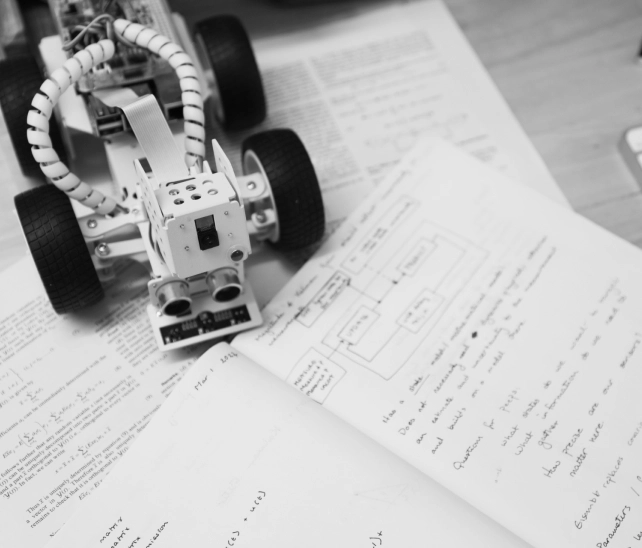

In [7]:
from viam.components.camera import Camera

robot = await connect()
camera = Camera.from_robot(robot, "camera0")
image = await camera.get_frame()
display(image)

# Don't forget to close the robot when you're done!
await robot.close()


You can also use the `RobotClient` to make service calls to the connected robot.

In [ ]:
from viam.services.vision import VisionServiceClient

async def vision():
    robot = await connect()
    vision = VisionServiceClient.from_robot(robot)
    detections = await vision.get_detections_from_camera("camera_1", "detector_1")

At the end, don't forget to close the connection

In [5]:
async def cleanup():
    await robot.close()

## Create custom components

While the main RDK is written in golang, you can create custom components in python and connect them to a robot as a `remote` component. This allows you to extend the functionality of a robot, or even create an entire robot exclusively in python.

The steps required in creating a custom component and connecting it to the RDK are
1. Subclass a component and implement desired functions
2. Create an `rpc.server.Server` instance and register the custom component
3. Start the `Server` and register the running server as a remote

### Subclass a component

The SDK provides a wide array of components to customize. You can browse through the API Reference to see all of them, but for now we'll use an `Arm` as an example. Our custom Arm will be extremely simple -- it will only save and return the positions provided to it.

Let's start by creating a directory called `my-python-robot`. Inside of that directory, create a file called `my_cool_arm.py`. The contents of `my_cool_arm.py` should be as follows:

In [1]:
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter
import IPython

with open('my_cool_arm.py') as f:
    code = f.read()

formatter = HtmlFormatter()
IPython.display.HTML('<style type="text/css">{}</style>{}'.format(
    formatter.get_style_defs('.highlight'),
    highlight(code, PythonLexer(), formatter)))

You can view more component implementations in the [examples](https://github.com/viamrobotics/python-sdk/blob/main/examples/server/v1/components.py).

### Register the custom component

Now that we've created the custom component, we must register it with a server so that it will be visible to any robots connecting to it.

In the same `my-python-robot` directory, create a new file called `python_server.py`.

In [3]:
# my-python-robot/python_server.py

import asyncio
from viam.rpc.server import Server

from my_cool_arm import MyCoolArm

async def main():
    srv = Server([MyCoolArm('my-arm')])

if __name__ == '__main__':
    try:
        asyncio.run(main())
    except:
        pass

/var/folders/vh/04mycgp163125hlq8k9bkl8w0000gn/T/ipykernel_50114/2037726754.py:15: RuntimeWarning: coroutine 'main' was never awaited
  pass


### Start the Server and add it as a Remote

Now that we have a server that knows about our custom Arm component, we need to start the server so it can receive gRPC calls. Once it's started, we can then register this server as a remote.

```python3
# my-python-robot/python_server.py

async def main():
  ...
  await srv.serve()
```
**NB**: When you call `srv.serve()`, the default host and port is `localhost:9090`. This can be changed by passing in a `host` and/or `port` parameter to the `serve` function.

To use this custom server as part of a larger robot, you’ll want to add it as a `remote` in the config for your main part.
```json
[
    {
      "name": "my-cool-python-components", // The name of the remote, can be anything
      "insecure": true,                    // Whether this connection should use SSL
      "address": "localhost:9090"          // The location of the remote robot
    }
  ]
```

And to ensure that the python server starts up with the rest of the robot, you can add it as a process. 
```json
[
  {
    "id": "0",
    "log": true,
    "name": "python",
    "args": [
      "/home/pi/my-python-robot/python_server.py"
    ]
  }
]
```

**NB**: The `viam-server` starts as a root process, so you may need to switch users to run the python SDK server.
```json
[
  {
    "id": "0",
    "log": true,
    "name": "sudo",
    "args": [
      "-u",
      "pi",
      "python",
      "/home/pi/my-python-robot/python-server.py"
    ]
  }
]
```
